In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/petfinder-pawpularity-score/sample_submission.csv
/kaggle/input/petfinder-pawpularity-score/train.csv
/kaggle/input/petfinder-pawpularity-score/test.csv
/kaggle/input/petfinder-pawpularity-score/test/c978013571258ed6d4637f6e8cc9d6a3.jpg
/kaggle/input/petfinder-pawpularity-score/test/4e429cead1848a298432a0acad014c9d.jpg
/kaggle/input/petfinder-pawpularity-score/test/43a2262d7738e3d420d453815151079e.jpg
/kaggle/input/petfinder-pawpularity-score/test/8f49844c382931444e68dffbe20228f4.jpg
/kaggle/input/petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg
/kaggle/input/petfinder-pawpularity-score/test/80bc3ccafcc51b66303c2c263aa38486.jpg
/kaggle/input/petfinder-pawpularity-score/test/e0de453c1bffc20c22b072b34b54e50f.jpg
/kaggle/input/petfinder-pawpularity-score/test/b03f7041962238a7c9d6537e22f9b017.jpg
/kaggle/input/petfinder-pawpularity-score/train/7954ebb5c90d9618e34959df0ad5f062.jpg
/kaggle/input/petfinder-pawpularity-score/train/2969162fab1d0e5a65e4ce02db26

In [2]:
! pip install pyyaml h5py

In [3]:
! mkdir /kaggle/working/cached
! mkdir /kaggle/working/output

In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
base_path = '/kaggle/input/petfinder-pawpularity-score/'
train_metadata = pd.read_csv(base_path+'train.csv')
test_metadata = pd.read_csv(base_path+'test.csv')

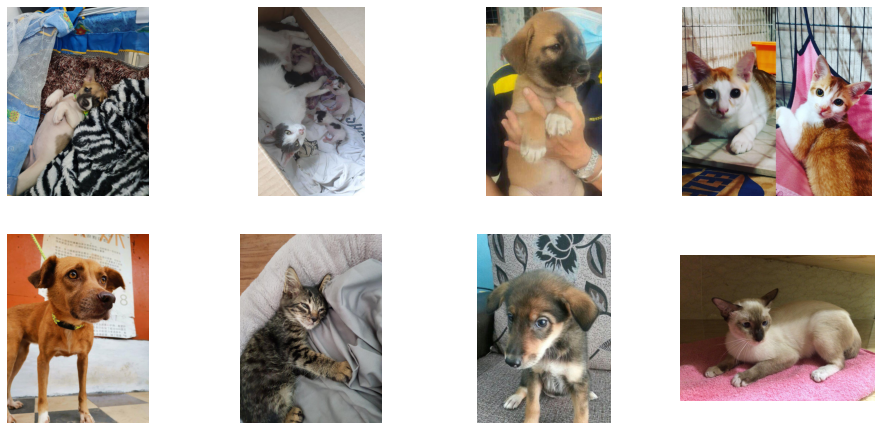

In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os


nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
train_images_fnames = os.listdir(base_path+'train')

pic_index+=8

next_image_pix = [os.path.join(base_path+'train', fname) 
                for fname in train_images_fnames[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(next_image_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [7]:
def add_image_format(item):
    return f"{item}.jpg"

train_image_names = list(train_metadata['Id'].apply(add_image_format))
test_image_names = list(test_metadata['Id'].apply(add_image_format))

In [8]:
train_metadata['filename'] = train_image_names
test_metadata['filename'] = test_image_names
X = train_metadata.drop(['Id'], axis=1) 
y = train_metadata['Pawpularity']
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, random_state=42)


number_of_items_in_batch = 50
total_batch_data_size = 20

data_X_train_batches = X_train#[X_train[i:i + number_of_items_in_batch] for i in range(0, len(X_train), total_batch_data_size)]
data_y_train_batches = y_train#[y_train[i:i + number_of_items_in_batch] for i in range(0, len(y_train), total_batch_data_size)]
data_X_dev_batches = X_dev#[X_dev[i:i + number_of_items_in_batch] for i in range(0, len(X_dev), total_batch_data_size)]
data_y_dev_batches = y_dev#[y_dev[i:i + number_of_items_in_batch] for i in range(0, len(y_dev), total_batch_data_size)]

X_test_data_ID = test_metadata['Id']
X_test_data = test_metadata.drop(['Id'], axis=1)

In [9]:
import cv2
class DataLoader:
    
    def prepare(self, batch_data_index=0, path='train'):
        self.batch_data_index = batch_data_index
        self.make_data(path)

    def get_images(self, data, path):
        npz_paths = []
        if type(self.batch_data_index) == str:
            _data_in_loop = data[:]['filename'] if path == 'train' else data['filename']
        else:
            _data_in_loop = data[self.batch_data_index]['filename'] if path == 'train' else data['filename']
        for i in _data_in_loop:
            pic_bgr_arr = cv2.imread(f'{base_path}{path}/{i}')
            resized = cv2.resize(pic_bgr_arr, (100, 100), interpolation = cv2.INTER_AREA)
            pic_rgb_arr = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

            npz_file_name = f"/kaggle/working/cached/{i.split('.')[0]}.npz"
            npz_paths.append(npz_file_name)
            np.savez_compressed(npz_file_name, pic=pic_rgb_arr/255)
        return npz_paths

    def get_X_y(self, df, is_test=False):
        X_pic, X_stats = [], []
        y = []

        for index, record in df.iterrows():
            loaded_npz = np.load(record['NPZ_Path'])

            pic = loaded_npz['pic']
            X_pic.append(pic)

            if not is_test:
                stats = record.drop(['Pawpularity', 'filename', 'NPZ_Path'])
                X_stats.append(stats)
                y.append(record['Pawpularity'])
            else:
                stats = record.drop(['filename', 'NPZ_Path'])
                X_stats.append(stats)


        X_pic, X_stats = np.array(X_pic), np.array(X_stats)
        if not is_test:
            y = np.array(y)
            return (X_pic, X_stats), y
        else:
            return (X_pic, X_stats)

    def make_data(self, path):
        if path == 'test':
            NPZ_Pathes = self.get_images(X_test_data, path)
            X_test_data['NPZ_Path'] = NPZ_Pathes
            (self.test_images, self.test_meta) = self.get_X_y(X_test_data, True)
        else:
            trained_data = self.get_images(data_X_train_batches, path)
            deved_data = self.get_images(data_X_dev_batches, path)

            if type(self.batch_data_index) == str:
                data_X_train_batches['NPZ_Path'] = trained_data
                data_X_dev_batches['NPZ_Path'] = deved_data  
                (self.train_images, self.train_meta), self.y_train = self.get_X_y(data_X_train_batches)
                (self.dev_images, self.dev_meta), self.y_dev = self.get_X_y(data_X_train_batches)
            else:
                data_X_train_batches[self.batch_data_index]['NPZ_Path'] = trained_data
                data_X_dev_batches[self.batch_data_index]['NPZ_Path'] = deved_data
                (self.train_images, self.train_meta), self.y_train = self.get_X_y(data_X_train_batches[self.batch_data_index])
                (self.dev_images, self.dev_meta), self.y_dev = self.get_X_y(data_X_train_batches[self.batch_data_index])



    def get_dev_data(self):
        return (np.asarray(self.dev_images).astype('float32'), np.asarray(self.dev_meta).astype('float32')), np.asarray(self.y_dev).astype('float32')

    def get_train_data(self):
        return (np.asarray(self.train_images).astype('float32'), np.asarray(self.train_meta).astype('float32')), np.asarray(self.y_train).astype('float32')

    def get_test_data(self):
        return (np.asarray(self.test_images).astype('float32'), np.asarray(self.test_meta).astype('float32'))


In [10]:
data = DataLoader()
data.prepare(path='test')
(test_images, test_meta) = data.get_test_data()
test_images.shape, test_meta.shape


((8, 100, 100, 3), (8, 12))

# Create a network for metadata

In [11]:
input_meta = tf.keras.layers.Input(shape=(12,))
meta_d = tf.keras.layers.Dense(50, activation='relu')(input_meta)
meta_d = tf.keras.layers.Dense(20, activation='relu')(meta_d)
meta_d = tf.keras.layers.Dense(12, activation='relu')(meta_d)
meta_model = tf.keras.Model(inputs=input_meta, outputs=meta_d)

2022-05-30 09:29:00.383550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:29:00.516960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:29:00.517865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:29:00.519065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Create CNN

In [12]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X) 
    ### END CODE HERE

    return X

In [13]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)  
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)  
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [14]:
def ResNet50(input_shape = (100, 100, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Normalizing data
    #_input = tf.keras.layers.Rescaling(1./255)(X_input)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(224, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [200, 200, 256], s = 1)
    X = identity_block(X, 3, [200, 200, 256])
    X = identity_block(X, 3, [200, 200, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)  
    X = identity_block(X, 3, [512, 512, 2048])  
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    # X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [15]:
cnn_model = ResNet50(input_shape = (100, 100, 3), classes = 1)

In [16]:
combined = tf.keras.layers.concatenate([cnn_model.output, meta_model.output])

In [17]:
X = Dense(len(train_image_names)+12, activation='relu')(combined)
X = Dense(50, activation='relu')(X)
X = Dense(10, activation='relu')(X)
X = Dense(1, activation='linear')(X)
final_model = Model(inputs=[cnn_model.input, meta_model.input], outputs=X)

In [18]:
final_model.compile(optimizer='adam', loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [19]:
#tf.keras.utils.plot_model(final_model, show_shapes=True, show_layer_names=False)

In [20]:
histories = []
data = DataLoader()
start_batch = 0
end_batch = 20
is_new_trained = save_model = False
total_batch_data_size = 1
for batch_data_index in range(total_batch_data_size):#[start_batch:end_batch]:
    if is_new_trained:
        final_model = tf.keras.models.load_model(f'/kaggle/working/output/final_model_{end_batch}')
        is_new_trained = False
    print(f'----------------Iterate_{batch_data_index}---------------')
    data.prepare(batch_data_index='all')

    (train_images, train_meta), y_train = data.get_train_data()
    (dev_images, dev_meta), y_dev = data.get_dev_data()
        
    histories.append(final_model.fit(x=[train_images, train_meta], y=y_train, validation_data=([dev_images, dev_meta], y_dev), verbose=1, epochs=190))
    if save_model:
        final_model.save(f'/kaggle/working/output/final_model_2')

----------------Iterate_0---------------


2022-05-30 09:34:06.678809: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1070400000 exceeds 10% of free system memory.
2022-05-30 09:34:07.850254: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1070400000 exceeds 10% of free system memory.
2022-05-30 09:34:08.672089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/190


2022-05-30 09:34:15.624992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


279/279 [==============================] - ETA: 0s - loss: 464.7880 - root_mean_squared_error: 21.5589

2022-05-30 09:34:43.266241: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1070400000 exceeds 10% of free system memory.


279/279 [==============================] - 44s 114ms/step - loss: 464.7880 - root_mean_squared_error: 21.5589 - val_loss: 423.3906 - val_root_mean_squared_error: 20.5765
Epoch 2/190
279/279 [==============================] - 32s 114ms/step - loss: 436.2909 - root_mean_squared_error: 20.8876 - val_loss: 423.9333 - val_root_mean_squared_error: 20.5896
Epoch 3/190
279/279 [==============================] - 32s 114ms/step - loss: 436.2825 - root_mean_squared_error: 20.8874 - val_loss: 446.9673 - val_root_mean_squared_error: 21.1416
Epoch 4/190
279/279 [==============================] - 29s 104ms/step - loss: 429.4724 - root_mean_squared_error: 20.7237 - val_loss: 437.1586 - val_root_mean_squared_error: 20.9083
Epoch 5/190
279/279 [==============================] - 29s 104ms/step - loss: 434.1576 - root_mean_squared_error: 20.8364 - val_loss: 423.2087 - val_root_mean_squared_error: 20.5720
Epoch 6/190
279/279 [==============================] - 29s 104ms/step - loss: 428.7674 - root_mean_squ

In [21]:
import json
path = '/kaggle/working/output/h.txt'
# if os.path.exists(path):
# history = json.load(open(path, 'r'))[0]
# else:
histories = [i.history for i in histories]
json.dump(histories, open(path, 'w'))


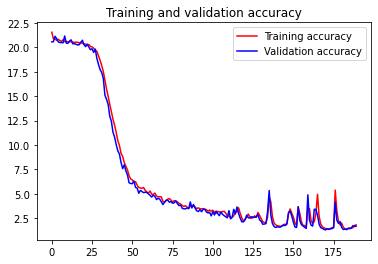

<Figure size 432x288 with 0 Axes>

In [22]:
acc = []
val_acc = []
loss = []
val_loss = []

for history in histories:
    acc += history['root_mean_squared_error']
    val_acc += history['val_root_mean_squared_error']
    loss += history['loss']
    val_loss += history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [23]:
test_predictions = final_model.predict([test_images, test_meta]).flatten()
test_predictions.shape

(8,)

In [24]:
predicted_result = pd.concat([X_test_data_ID, pd.Series(test_predictions)], axis=1)
predicted_result.columns=['Id', "Pawpularity"]

In [25]:
predicted_result

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,34.852306
1,43a2262d7738e3d420d453815151079e,40.212128
2,4e429cead1848a298432a0acad014c9d,48.375874
3,80bc3ccafcc51b66303c2c263aa38486,18.154381
4,8f49844c382931444e68dffbe20228f4,25.188597
5,b03f7041962238a7c9d6537e22f9b017,39.860973
6,c978013571258ed6d4637f6e8cc9d6a3,22.256838
7,e0de453c1bffc20c22b072b34b54e50f,27.445887


In [26]:
predicted_result.to_csv('submission.csv', index=False)

In [27]:
final_model.save(f'/kaggle/working/output/final_model_2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
